%%latex
\tableofcontents

# Preparations

In [290]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# ENV_NAME = 'colab'
ENV_NAME = 'local'
path_prefix = {'colab': '/content/drive/MyDrive/ComputerVision/CV-Phase1/', 
                'local': './Images/'}

Open image using pyplot:

In [3]:
def loadImage(name, path_prefix=path_prefix[ENV_NAME]):
  image = plt.imread(path_prefix + name)
  print(image.shape)
  print(type(image))
  return image

We start by uploading our sample image, here `mosque.bmp`.

(488, 695, 3)
<class 'numpy.ndarray'>


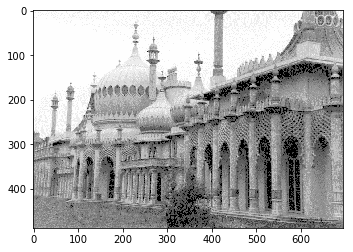

In [4]:
mosque = loadImage('mosque.bmp')
plt.imshow(mosque)

# Box Filter (Mean Filter)


Box filter essentially takes a window of pixels and finds the mean value of all the pixels in the window. Box blur is usually implemented in odd-sized square kernels (e.g. 3×3, 5×5, etc.).

## Convolution Method
Function `conv_box_blur()` uses `convolve2d` (as defined below) to implement the box filter. `convolve_bands()`can be used with various convolution kernels.

In [6]:
def convolve2d(img, kernel):
    kernel_size = kernel.shape[0]
    img_shape = img.shape
    # pad the image with zeros
    padded_img = np.zeros((img_shape[0] + kernel_size - 1, img_shape[1] + kernel_size - 1))
    padded_img[kernel_size//2:img_shape[0] + kernel_size//2, kernel_size//2:img_shape[1] + kernel_size//2] = img
    convolved = np.zeros(img.shape, dtype=np.uint8)
    
    for i in range( kernel_size - 1,img_shape[0]):
        for j in range( kernel_size - 1,img_shape[1]):
            convolved[i, j] = np.sum(padded_img[i:(i + kernel_size), j:(j + kernel_size)] * kernel)
    return convolved

In [7]:
# convolution on all channels
def convolve_bands(img, kernel):
    dims = []
    for dim in range(img.shape[2]):
        img_conv_d = convolve2d(img[:,:,dim], kernel)
        # add to previous dimensions
        dims.append(img_conv_d)
    img_conv = np.stack(dims, axis=2).astype("uint8")
    return img_conv

# and the box blur using convolution
def conv_box_blur (img, kernel_size=(3, 3)):
    window = np.ones(kernel_size)
    window /= np.sum(window, axis=(0,1))
    img_conv = convolve_bands(img, window)
    return img_conv

The resulting image for various kernel sizes is shown below, including time taken to compute the image.

In [280]:
# setting dataframe for time comparison
df = pd.DataFrame(columns=['algorithm', 'kernel_size', 'time'])

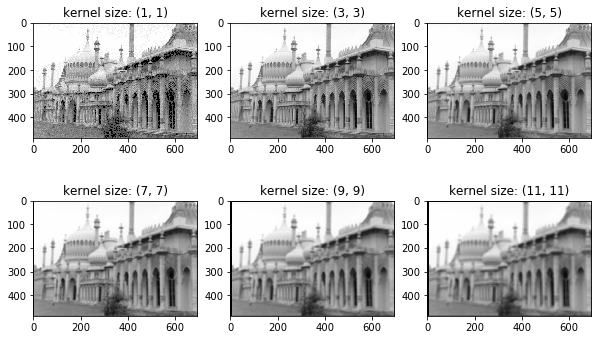

In [281]:
import time
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
for i, kernel_size in enumerate([(1,1), (3, 3), (5, 5), (7, 7), (9, 9), (11, 11)]):
    t0 = time.time()
    mosque_blur = conv_box_blur(mosque, kernel_size)
    tdf = pd.DataFrame({'algorithm': 'classic', 'kernel_size': [kernel_size[0]] , 'time': time.time() - t0})
    df = pd.concat([df, tdf])
    axs[i//3, i%3].imshow(mosque_blur)
    axs[i//3, i%3].set_title(f'kernel size: {kernel_size}')
plt.show()

In [282]:
# normalise dataframe index
df.index = range(len(df))
df

,algorithm,kernel_size,time
0,classic,1,7.420373
1,classic,3,7.899047
2,classic,5,8.472929
3,classic,7,8.278069
4,classic,9,9.172044
5,classic,11,9.070878


## Dynamic Programming

The following method uses a summing table, which is a table of sums of the pixels in the window. The summing table is computed first and then used to compute the final image.
The sum table size is similar to image's, and traversing it has ${O(1)}$ time complexity.

In [214]:
def box_blur(img, kernel_size=(3, 3)):
    # pad new image with 0s
    new_img = np.zeros((img.shape[0] + kernel_size[0] - 1, img.shape[1] + kernel_size[0] - 1, img.shape[2]), dtype=np.uint8)
    new_img[kernel_size[0]//2:img.shape[0] + kernel_size[0]//2, kernel_size[0]//2:img.shape[1] + kernel_size[0]//2, :] = img
    # most of the usage works on distance from centre of the kernel
    width, height, _ = new_img.shape
    r = kernel_size[0] // 2
    area = kernel_size[0] * kernel_size[1]
    table = summed_table(new_img)
    for x in range(r + 1, width - r - 1):
        for y in range(r + 1, height - r - 1):
            sum_pixels = np.add(table[x-r-1, y-r-1, :], 
                            np.subtract(
                                np.subtract(table[x+r, y+r, :], table[x-r-1, y+r, :]), 
                                table[x+r, y-r-1, :]))
            # calculate mean using sum of window
            new_img[x, y, :] = (sum_pixels//area).astype(np.uint8)
    return new_img

In [215]:
def summed_table(img):
    width, height, _ = img.shape
    table = np.zeros(img.shape, dtype=np.uint32)
    table[0, 0, : ] = img[0, 0, :]
    # edge management (akin to padding)
    for x in range(1, width):
        table[x, 0, :] = np.add(img[x, 0, :], table[x-1, 0, :])
    for y in range(1, height):
        table[0, y, :] = np.add(img[0, y, :], table[0, y-1, :])
    for x in range(1, width - 1):
        for y in range(1, height - 1):
            table [x, y, :] = sum([img[x, y, :], table[x-1, y, :], table[x, y-1, :], np.negative(table[x-1, y-1, :])])
    return table

In [216]:
# setting dataframe for time comparison
ndf = pd.DataFrame(columns=['algorithm', 'kernel_size', 'time'])

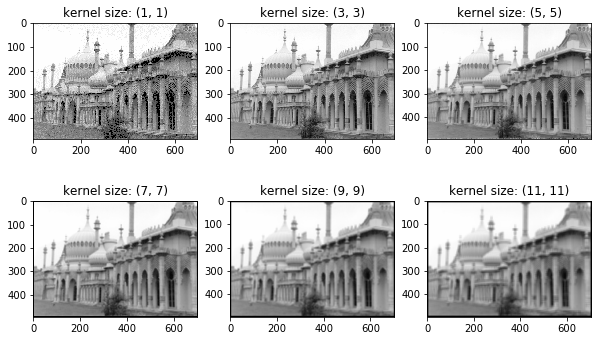

In [217]:
import time
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
for i, kernel_size in enumerate([(1,1), (3, 3), (5, 5), (7, 7), (9, 9), (11, 11)]):
    t0 = time.time()
    mosque_blur = box_blur(mosque, kernel_size)
    tdf = pd.DataFrame({'algorithm': 'DP', 'kernel_size': [kernel_size[0]] , 'time': time.time() - t0})
    ndf = pd.concat([ndf, tdf])
    axs[i//3, i%3].imshow(mosque_blur)
    axs[i//3, i%3].set_title(f'kernel size: {kernel_size}')
plt.show()

In [218]:
# normalise dataframe index
ndf.index = range(len(ndf))
ndf

,algorithm,kernel_size,time
0,DP,1,4.341127
1,DP,3,4.086927
2,DP,5,4.038003
3,DP,7,4.024780
4,DP,9,4.379934
5,DP,11,4.433985


The chart below shows the time taken to compute the image for various kernel sizes, with classic solution and DP. Time of DP has low variance on different kernel sizes, showing its ${O(1)}$ complexity.

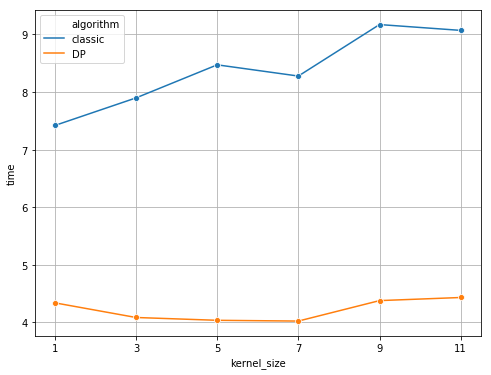

In [283]:
import seaborn as sns
dataframe = pd.concat([df, ndf])
fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(x='kernel_size', y='time', hue='algorithm', data=dataframe, ax=ax, marker='o')
ax.set_xticks(np.arange(1, 12, 2))
plt.grid()
plt.show()

# Robert Edge Detection


In [327]:
# converting rgb to greyscale
def rgb2grey(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    grey = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return grey

In [329]:
# robert 2d kernels along x and y
mosque_g = rgb2grey(mosque)
robert_x = np.array([[1, 0], [0, -1]])
robert_y = np.array([[0, 1], [-1, 0]])
mosque_rx = convolve2d(mosque_g, robert_x)
mosque_ry = convolve2d(mosque_g, robert_y)

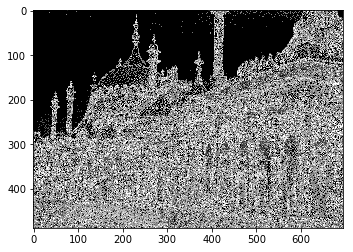

In [333]:
mosque_robert = np.sqrt(np.square(mosque_rx) + np.square(mosque_ry))
mosque_robert = np.asarray(np.clip(mosque_robert,0,255), dtype="uint8")
plt.gray()
plt.imshow(mosque_robert)

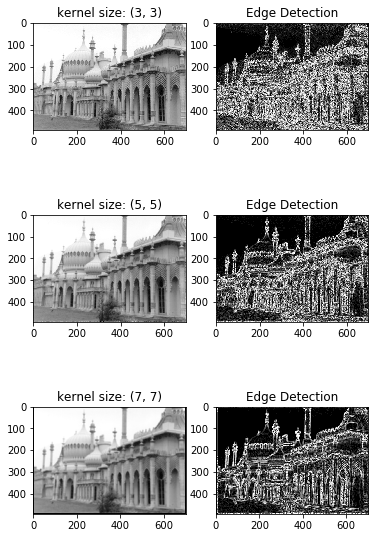

In [334]:
robert_x = np.array([[1, 0], [0, -1]])
robert_y = np.array([[0, 1], [-1, 0]])
fig, axs = plt.subplots(3,2, figsize=(6, 10))
for i, kernel_size in enumerate([(3,3), (5,5), (7,7)]):
    blurred = box_blur(mosque, kernel_size)
    blurred = rgb2grey(blurred)
    mosque_rx = convolve2d(blurred, robert_x)
    mosque_ry = convolve2d(blurred, robert_y)
    mosque_robert = np.sqrt(np.square(mosque_rx) + np.square(mosque_ry))
    mosque_robert = np.asarray(np.clip(mosque_robert,0,255), dtype="uint8")
    axs[i%3, 0].imshow(blurred)
    axs[i%3, 0].set_title(f'kernel size: {kernel_size}')
    axs[i%3, 1].imshow(mosque_robert)
    axs[i%3, 1].set_title('Edge Detection')
plt.show()

In the last image, the edges are more clearly visible, and the noise is reduced.

# Multiple Application of Mean Filter
## Double Application of 3×3
First we observe the application of a double (3×3) mean filter to the image and compare it with a single (5×5) mean filter. The difference in results is especially clear on the rightmost arch pattern in the image.

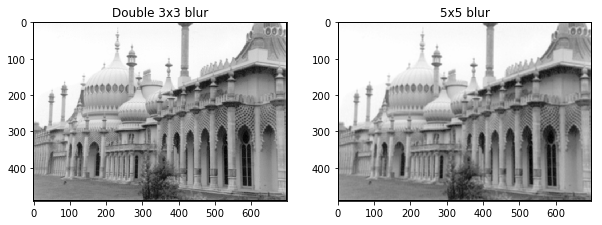

In [335]:
fig, axs = plt.subplots (1, 2, figsize = (10,5))
blur_3 = box_blur(mosque, (3,3))
double_blur = box_blur(blur_3, (3,3))
axs[0].imshow(double_blur)
axs[0].set_title('Double 3x3 blur')
blur_5 = box_blur(mosque, (5,5))
axs[1].imshow(blur_5)
axs[1].set_title('5x5 blur')
plt.show()


By applying a mean filter M twice to an image I, we have:
$$ {I_F = M \star (M \star I) = (M \star M) \star I  = M2 \star I }$$
Where ${M2 = M \star M}$.
Therefore, application of a (3×3) mean filter twice is equivalent to the below matrix:
$${\dfrac {1}{81}}\begin{bmatrix}
1 & 2 & 3 & 2 & 1 \\
2 & 4 & 6 & 4 & 2 \\
3 & 6 & 9 & 6 & 3 \\
2 & 4 & 6 & 4 & 2 \\
1 & 2 & 3 & 2 & 1 \\
\end{bmatrix}$$

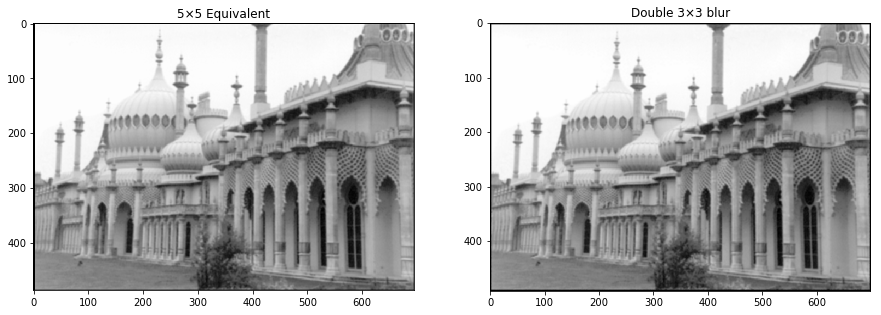

In [336]:
fig, axs = plt.subplots(1, 2, figsize = (15, 7))
kernel = (1/81)*np.array([[1, 2, 3, 2, 1],
        [2, 4, 6, 4, 2],
        [3, 6, 9, 6, 3],
        [2, 4, 6, 4, 2],
        [1, 2, 3, 2, 1]])
blur_m2 = convolve_bands(mosque, kernel)
axs[0].imshow(blur_m2)
axs[0].set_title('5×5 Equivalent')
axs[1].imshow(double_blur)
axs[1].set_title('Double 3×3 blur')
plt.show()

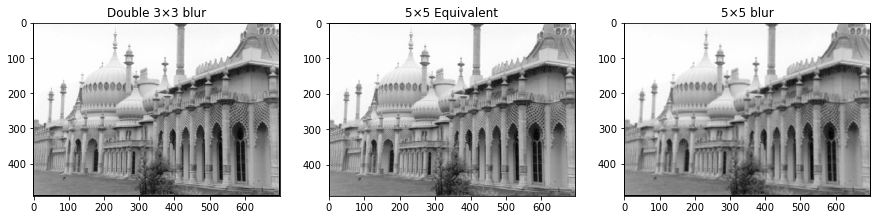

In [338]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))
axs[0].imshow(double_blur)
axs[0].set_title('Double 3×3 blur')
axs[1].imshow(blur_m2)
axs[1].set_title('5×5 Equivalent')
axs[2].imshow(blur_5)
axs[2].set_title('5×5 blur')
plt.show()

## Triple Application of 3×3
With regards to the previous section, the triple application of a 3×3 box filter would be ${M3 = M \star M \star M}$. Therefore, the following matrix is equivalent to the triple application of a 3×3 box filter:
$${\dfrac{1}{729}}\begin{bmatrix}
1 & 3 & 6 & 7 & 6 & 3 & 1 \\
3 & 9 & 18 & 21 & 18 & 9 & 3 \\
6 & 18 & 36 & 42 & 36 & 18 & 6 \\
7 & 21 & 42 & 49 & 42 & 21 & 7 \\
6 & 18 & 36 & 42 & 36 & 18 & 6 \\
3 & 9 & 18 & 21 & 18 & 9 & 3 \\
1 & 3 & 6 & 7 & 6 & 3 & 1 \\
\end{bmatrix}$$


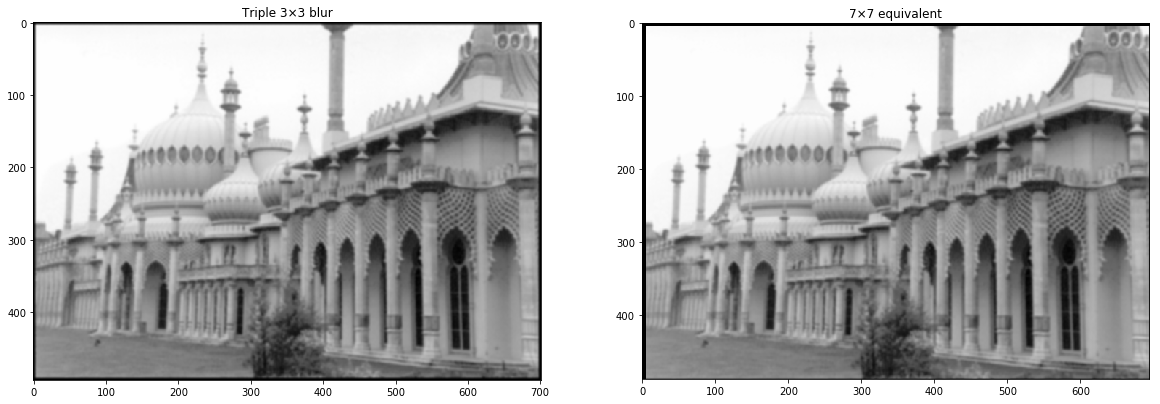

In [289]:
fig, axs = plt.subplots(1, 2, figsize = (20, 10))
kernel = (1/729)*np.array([[ 1,  3,  6,  7,  6,  3,  1],
       [ 3,  9, 18, 21, 18,  9,  3],
       [ 6, 18, 36, 42, 36, 18,  6],
       [ 7, 21, 42, 49, 42, 21,  7],
       [ 6, 18, 36, 42, 36, 18,  6],
       [ 3,  9, 18, 21, 18,  9,  3],
       [ 1,  3,  6,  7,  6,  3,  1]])

blur333 = convolve_bands(mosque, kernel)
triple_blur3 = box_blur(double_blur3, (3,3))

axs[0].imshow(triple_blur3)
axs[0].set_title('Triple 3×3 blur')
axs[1].imshow(blur333)
axs[1].set_title('7×7 equivalent')
plt.show()

Per above images, the quality (smoothness) of both images are exactly the same, however, the padding of the images are different due to different base padding (transition is smoother in triple application of 3×3).